# NaiveBayes 분류 기본 코드

sklearn에서 제공하는 NaiveBayes 알고리즘은 독립변수의 유형에 따라 세가지로 구분된다.

나이브 베이즈는 선형회귀와 달리 명목형 독립변수를 더미변수로 만들 필요가 없다. 모델을 학습하는 것이 아니라, 각 변수의 카테고리를 이용해서 확률 계산을 하는 것이 때문.

| 알고리즘 | 설명 |
|---|---|
| CategoricalNB | 범주형 변수 |
| MultinomialNB | 빈도수 |
| GaussianNB | 연속형 변수 |

## #01. 준비작업

### [1] 패키지 가져오기

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Intel SKlearn 하드웨어 가속 패치 설정
import sys
if sys.platform == 'win32':
    from sklearnex import patch_sklearn
    patch_sklearn()

from hossam.util import *
from hossam.plot import *
from hossam.analysis import *
from hossam.classification import *

from sklearn.naive_bayes import GaussianNB

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## #02. 이진분류 - 피마 인디언 당뇨병 데이터 셋

### [1] 데이터 가져오기

In [2]:
origin = my_read_excel("https://data.hossam.kr/mldata/pima_indians_diabetes.xlsx", categories=['Outcome'], info=False)

### [2] 데이터 전처리

1. 종속변수 라벨링 및 형변환
2. 훈련/검증 데이터 분리

In [3]:
# 정제 대상 필드명
zero_features = ['Glucose', 'BloodPressure','SkinThickness','Insulin','BMI']

# `0`값을 결측치로 대체후 평균으로 다시 치환
df = origin.copy()
df[zero_features] = df[zero_features].replace(0, np.nan)
df2 = my_replace_missing_value(df)

df2['Outcome'] = df2['Outcome'].astype('int')

x_train, x_test, y_train, y_test = my_train_test_split(df2, yname='Outcome', test_size=0.2, scalling=False)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((614, 8), (154, 8), (614,), (154,))

### [3] GaussianNB 분류 모델 구현

| 하이퍼파라미터   | 설명 | 기본값 | 추천 사항 | `GridSearchCV` 추천값 |
|-----------------|------|--------|-----------|------------------------|
| `priors`        | 클래스의 사전 확률을 지정<br/>`None`이 아니면, 각 클래스의 사전 확률을 의미함 | `None`   | 불균형 데이터셋을 다룰 때나 특정 클래스의 중요도를 조정하고 싶을 때 사전 확률을 설정할 수 있다.<br/>대부분은 데이터에서 학습되는 확률을 사용하는 것이 좋다. | 추천값 설정에는 데이터 특성이 반영되어야 하므로 일반적인 값 제공 어려움 |
| `var_smoothing`  | 예측을 위한 분산의 일부를 최대 분산에 추가해서 계산하는데 사용되는 값<br/>과적합을 방지하기 위해 사용된다. | `1e-9`  | 이 값에 따라 모델의 성능이 달라질 수 있음 | `{'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]}` |

> `priors` 파라미터는 없는 샘 치는게 좋음. ^^;;;

In [4]:
estimator = GaussianNB(var_smoothing=1e-09)

estimator.fit(x_train, y_train)
print("훈련데이터 점수: ", estimator.score(x_train, y_train))
print("검증데이터 점수: ", estimator.score(x_test, y_test))      

훈련데이터 점수:  0.749185667752443
검증데이터 점수:  0.7727272727272727


### [4] 성능평가

[분류분석 성능평가]
+-------------------+--------------+--------------+-----------------------------------------------------------+
|                   |   훈련데이터 |   검증데이터 | 설명                                                      |
|-------------------+--------------+--------------+-----------------------------------------------------------|
| 정확도(Accuracy)  |     0.749186 |     0.772727 | 예측 결과(TN,FP,TP,TN)가 실제 결과(TP,TN)와 일치하는 정도 |
| 정밀도(Precision) |     0.645833 |     0.716981 | 양성으로 예측한 결과(TP,FP) 중 실제 양성(TP)인 비율       |
| 재현율(Recall)    |     0.590476 |     0.655172 | 실제 양성(TP,FN) 중 양성(TP)으로 예측한 비율              |
| 위양성율(Fallout) |     0.168317 |      0.15625 | 실제 음성(FP,TN) 중 양성(FP)으로 잘못 예측한 비율         |
| 특이성(TNR)       |     0.831683 |      0.84375 | 실제 음성(FP,TN) 중 음성(TN)으로 정확히 예측한 비율       |
| F1 Score          |     0.616915 |     0.684685 | 정밀도와 재현율의 조화평균                                |
| AUC               |     0.817056 |     0.873743 | ROC Curve의 면적으로, 1에 가까울수록 좋은 모델            |
+--

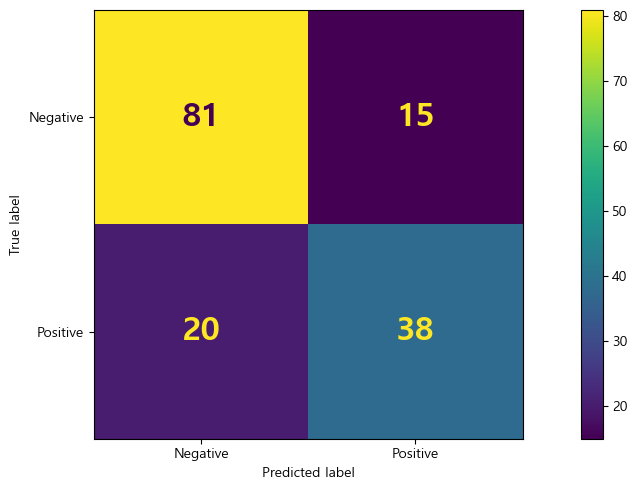

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



[Roc Curve]


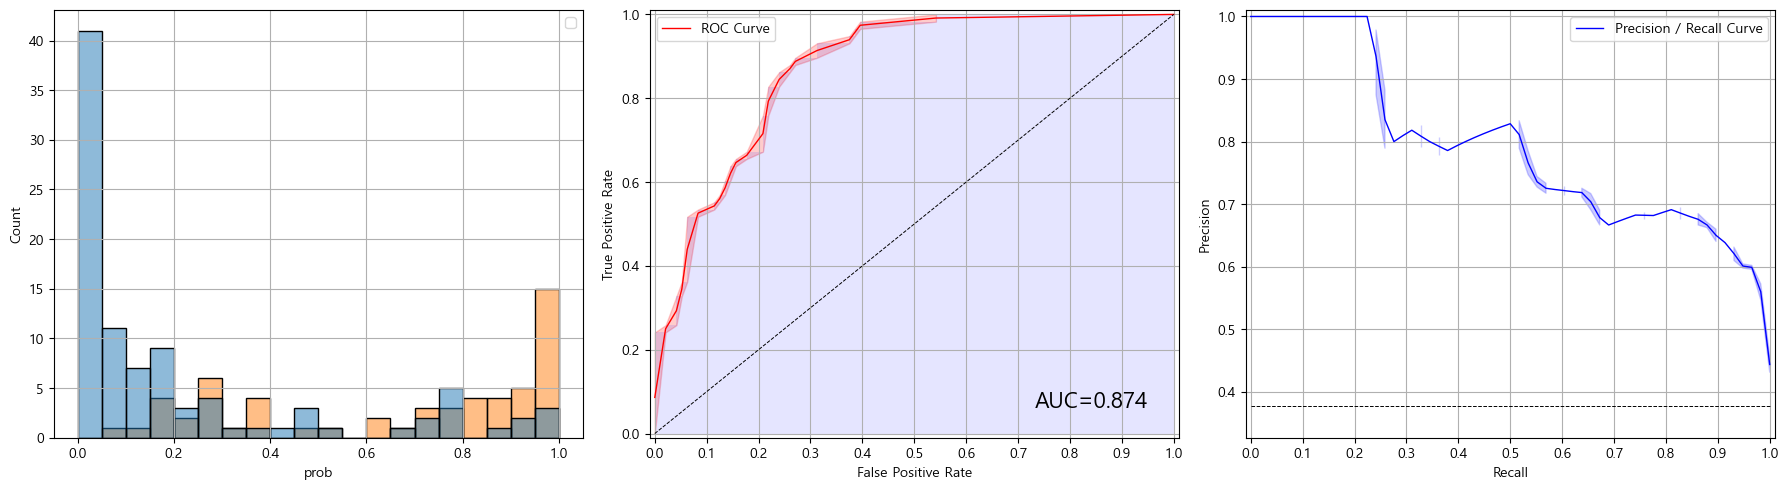


[학습곡선]


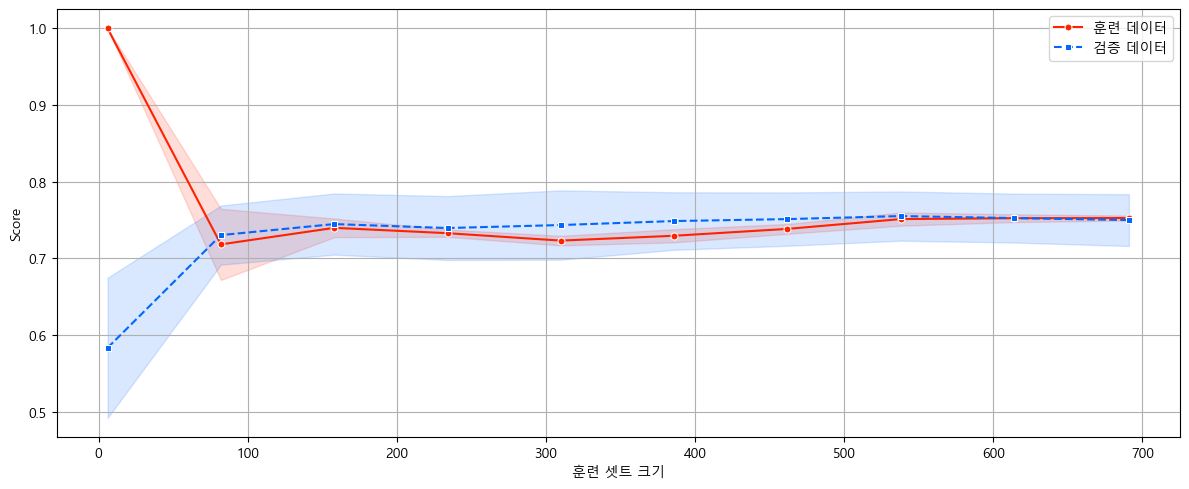

In [5]:
my_classification_result(estimator, x_train, y_train, x_test, y_test)

### [5] 모듈화 기능 확인

<class 'sklearn.naive_bayes.GaussianNB'>는 n_jobs를 허용하지 않음
[교차검증 TOP5]
+----+-----------------+-------------------+
|    |   var_smoothing |   mean_test_score |
|----+-----------------+-------------------|
|  4 |           1e-05 |           0.75899 |
|  2 |           1e-07 |          0.750833 |
|  3 |           1e-06 |          0.749207 |
|  0 |           1e-09 |          0.749207 |
|  1 |           1e-08 |          0.749207 |
+----+-----------------+-------------------+

[분류분석 성능평가]
+-------------------+--------------+--------------+-----------------------------------------------------------+
|                   |   훈련데이터 |   검증데이터 | 설명                                                      |
|-------------------+--------------+--------------+-----------------------------------------------------------|
| 정확도(Accuracy)  |     0.758958 |     0.772727 | 예측 결과(TN,FP,TP,TN)가 실제 결과(TP,TN)와 일치하는 정도 |
| 정밀도(Precision) |     0.663158 |     0.716981 | 양성으로 예측한 결과(TP,FP) 중 실제 양성(TP)인 비율       |
| 재

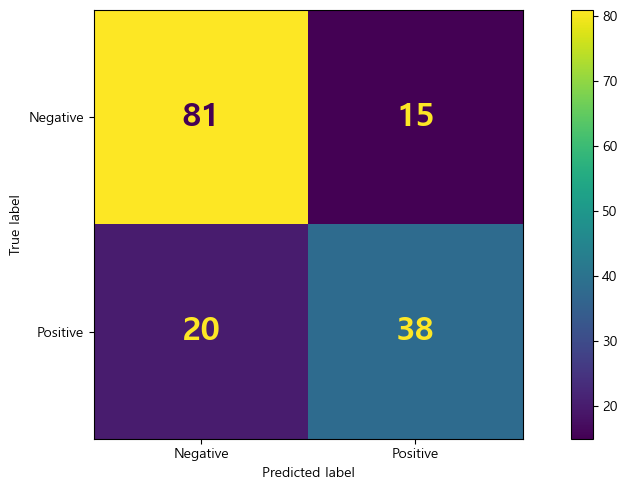

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



[Roc Curve]


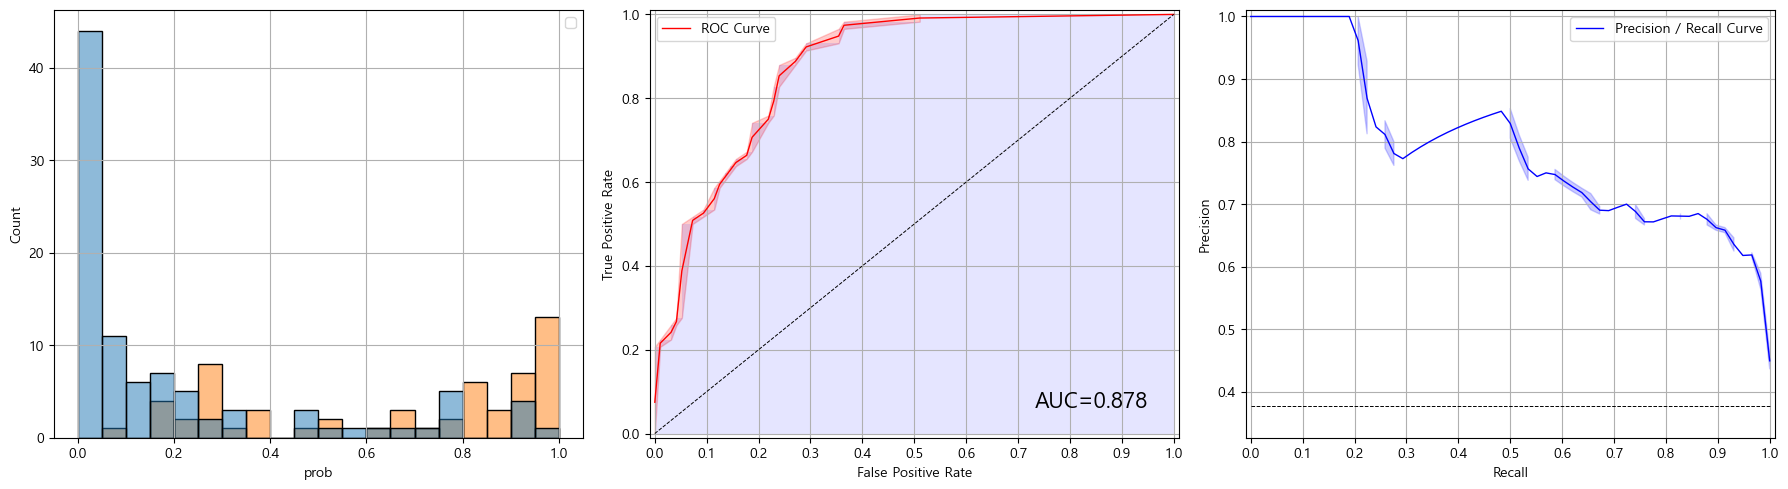


[학습곡선]


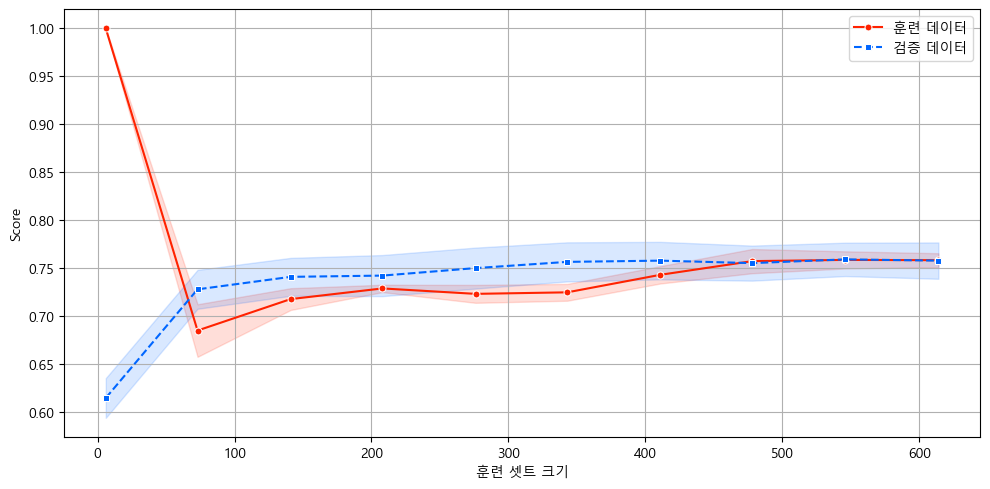

CPU times: total: 1.75 s
Wall time: 1.83 s


GaussianNB(var_smoothing=1e-05)

In [6]:
%%time
my_nb_classification(x_train, y_train, x_test, y_test)

### [6] 모든 모형에 대한 성능 비교

In [7]:
%%time
my_classification(x_train, y_train, x_test, y_test)

<class 'sklearn.naive_bayes.GaussianNB'>는 n_jobs를 허용하지 않음
+----------------------+---------------------------+--------------------+---------------------+------------------+---------------------+---------------+------------+----------+
|                      |   의사결정계수(Pseudo R2) |   정확도(Accuracy) |   정밀도(Precision) |   재현율(Recall) |   위양성율(Fallout) |   특이성(TNR) |   F1 Score |      AUC |
|----------------------+---------------------------+--------------------+---------------------+------------------+---------------------+---------------+------------+----------|
| GaussianNB           |                         0 |           0.772727 |            0.716981 |         0.655172 |             0.15625 |       0.84375 |   0.684685 | 0.873743 |
| LogisticRegression   |                  0.325592 |           0.766234 |            0.761905 |         0.551724 |            0.104167 |      0.895833 |       0.64 | 0.866739 |
| KNeighborsClassifier |                         0 |            0.74026 |      

## #03. 다항분류 - WINE 데이터 셋

### [1] 데이터 가져오기

In [8]:
origin = my_read_excel("https://data.hossam.kr/mldata/wine.xlsx", categories=['class'], info=False)

### [2] 데이터 전처리

1. 종속변수 타입 변환
2. 훈련/검증 데이터 분할 + 데이터 스케일링

In [10]:
df = origin.copy()
df['class'] = df['class'].astype('int')

x_train, x_test, y_train, y_test = my_train_test_split(df,yname='class',scalling=True)
x_train.shape, x_test.shape, y_train.shape, y_test.shape 

((142, 13), (36, 13), (142,), (36,))

### [3] GaussianNB 분류 모델 구현

<class 'sklearn.naive_bayes.GaussianNB'>는 n_jobs를 허용하지 않음
[교차검증 TOP5]
+----+-----------------+-------------------+
|    |   var_smoothing |   mean_test_score |
|----+-----------------+-------------------|
|  0 |           1e-09 |          0.971429 |
|  1 |           1e-08 |          0.971429 |
|  2 |           1e-07 |          0.971429 |
|  3 |           1e-06 |          0.971429 |
|  4 |           1e-05 |          0.971429 |
+----+-----------------+-------------------+

[분류분석 성능평가]
+-------------------+--------------+--------------+-----------------------------------------------------------+
|                   |   훈련데이터 |   검증데이터 | 설명                                                      |
|-------------------+--------------+--------------+-----------------------------------------------------------|
| 정확도(Accuracy)  |     0.978873 |            1 | 예측 결과(TN,FP,TP,TN)가 실제 결과(TP,TN)와 일치하는 정도 |
| 정밀도(Precision) |     0.978654 |            1 | 양성으로 예측한 결과(TP,FP) 중 실제 양성(TP)인 비율       |
| 재

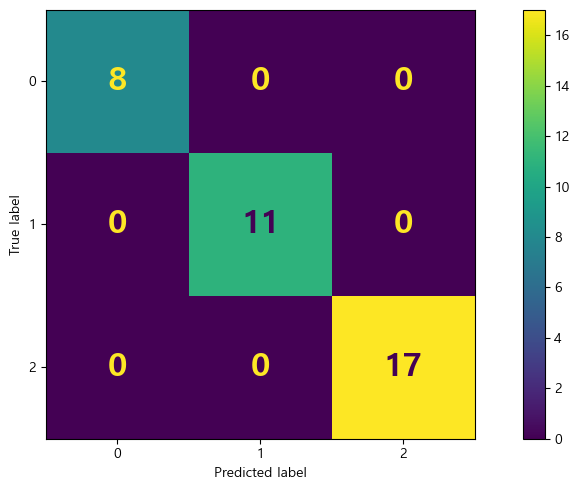


[Roc Curve]


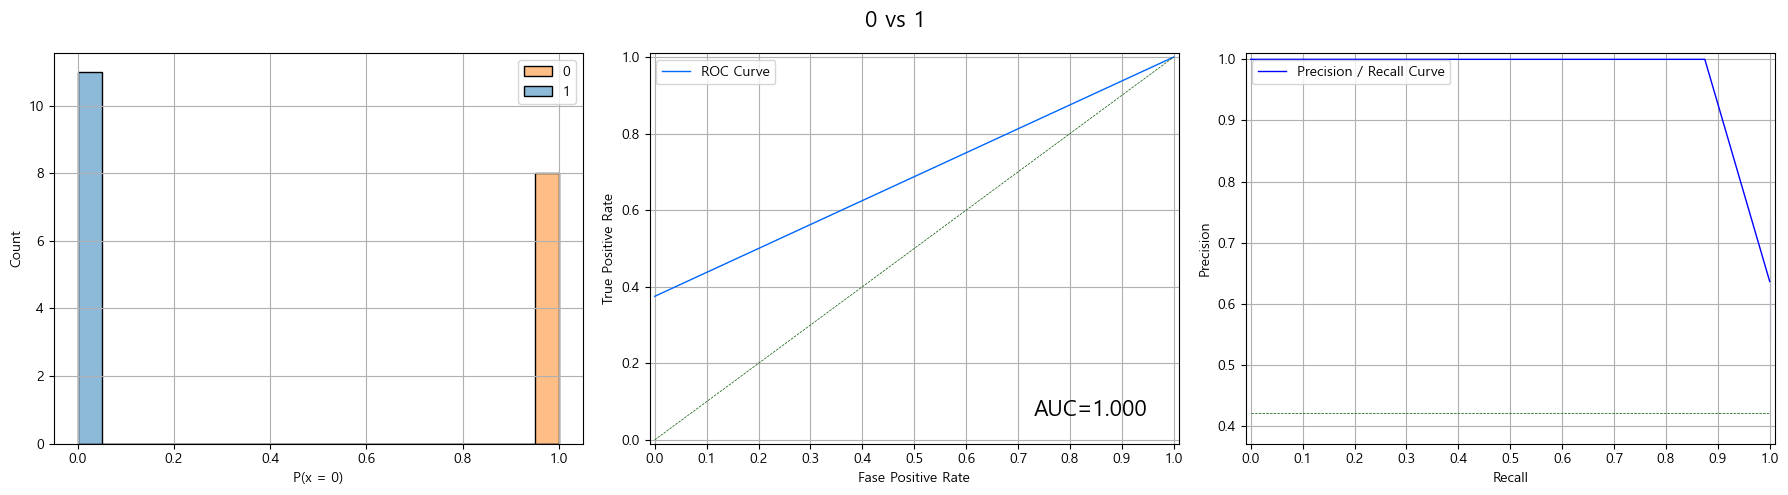

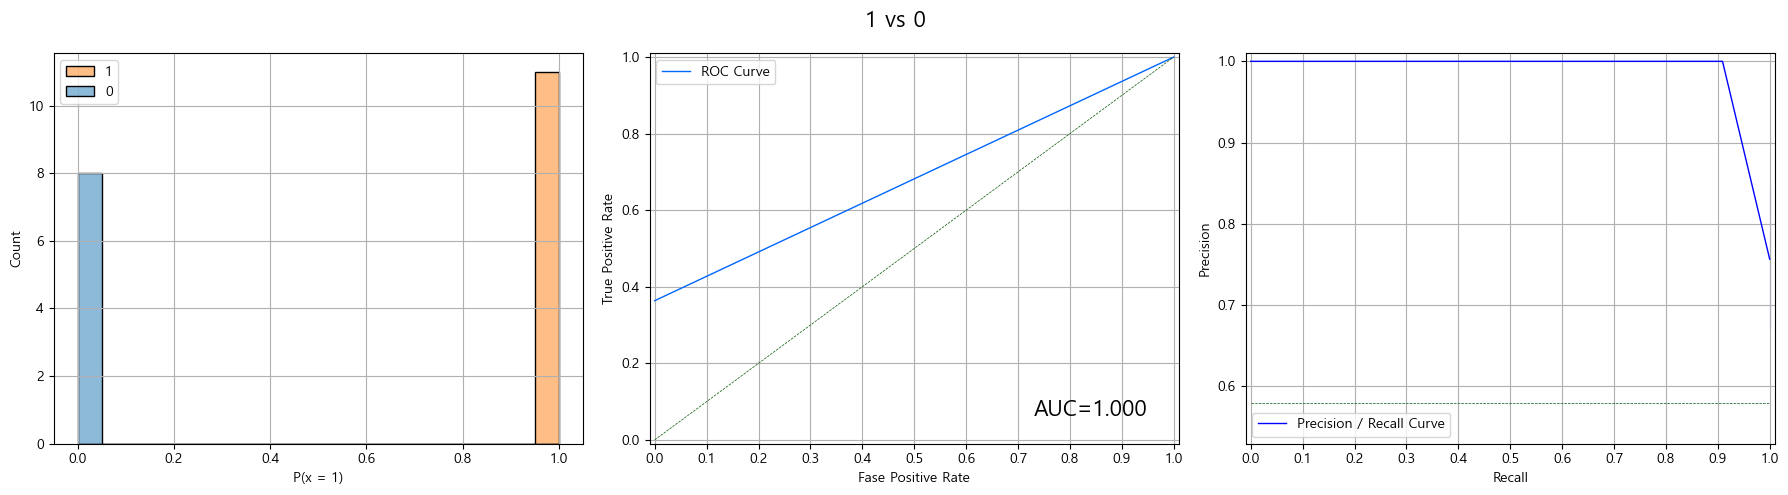

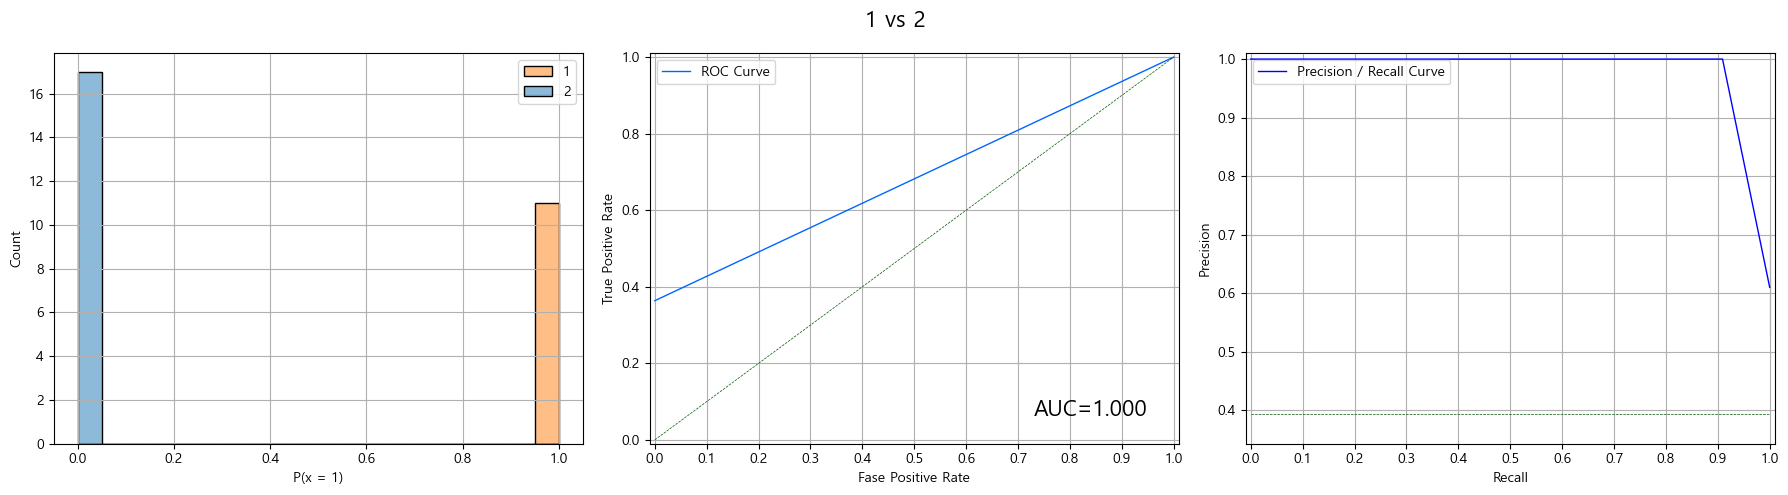

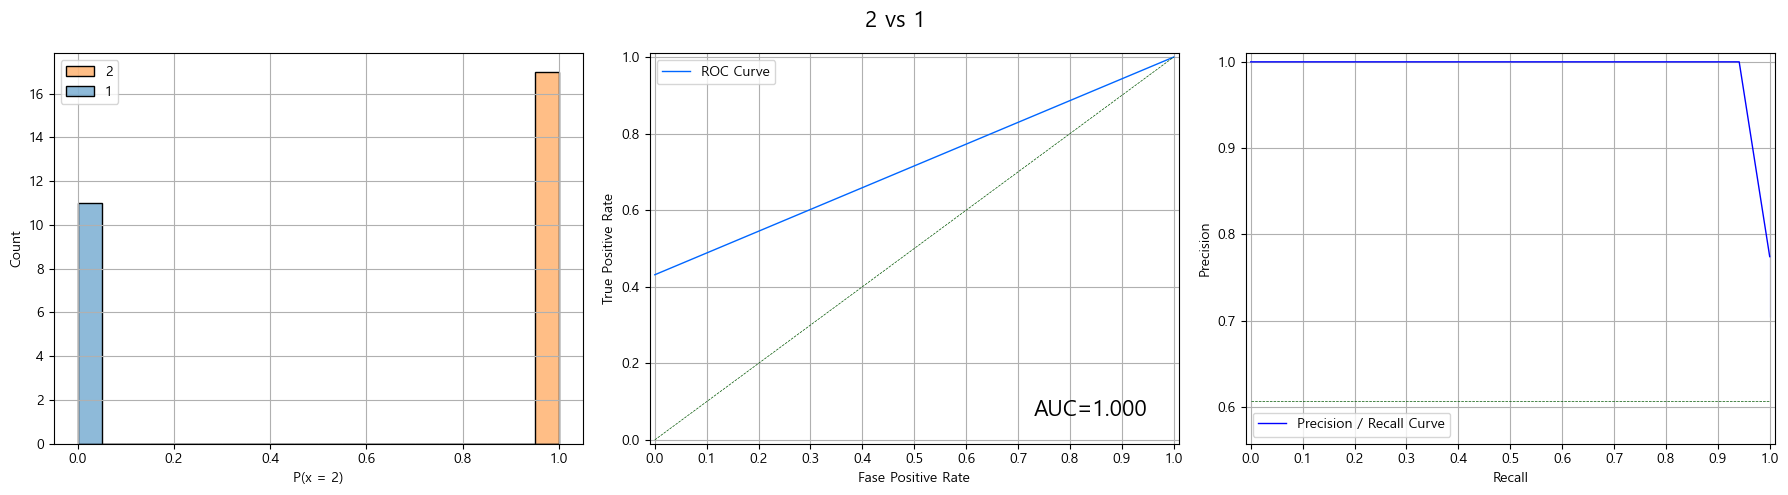

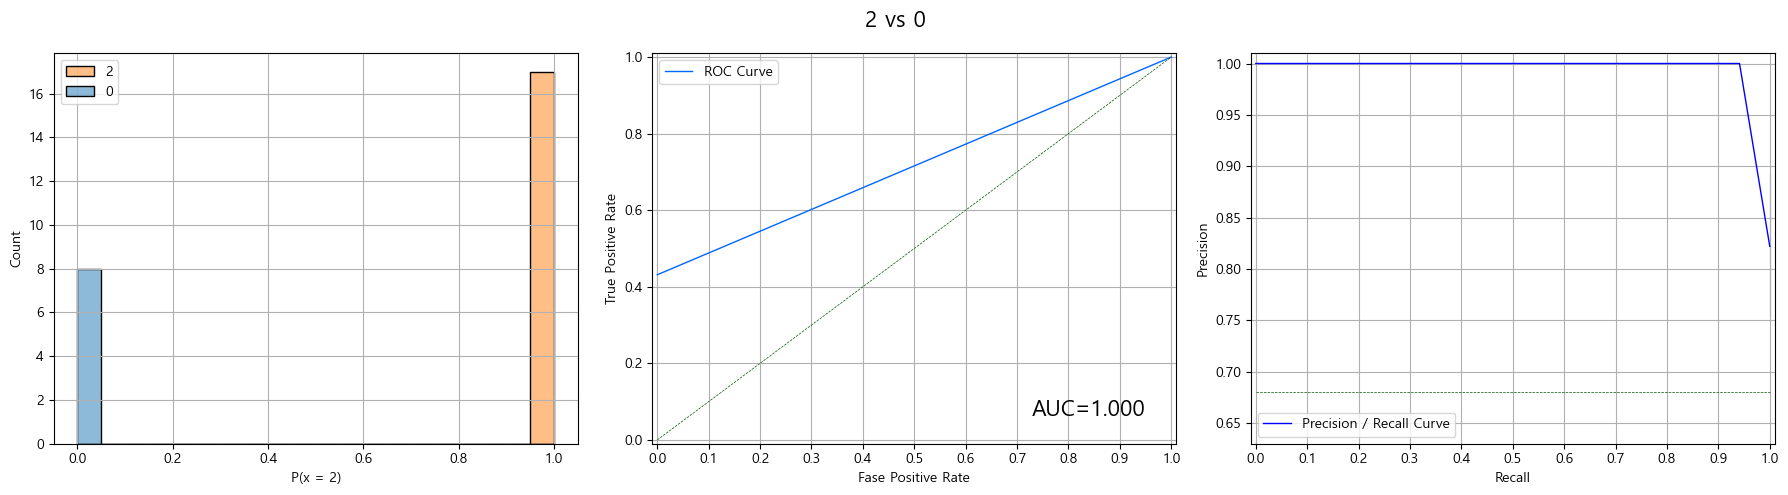

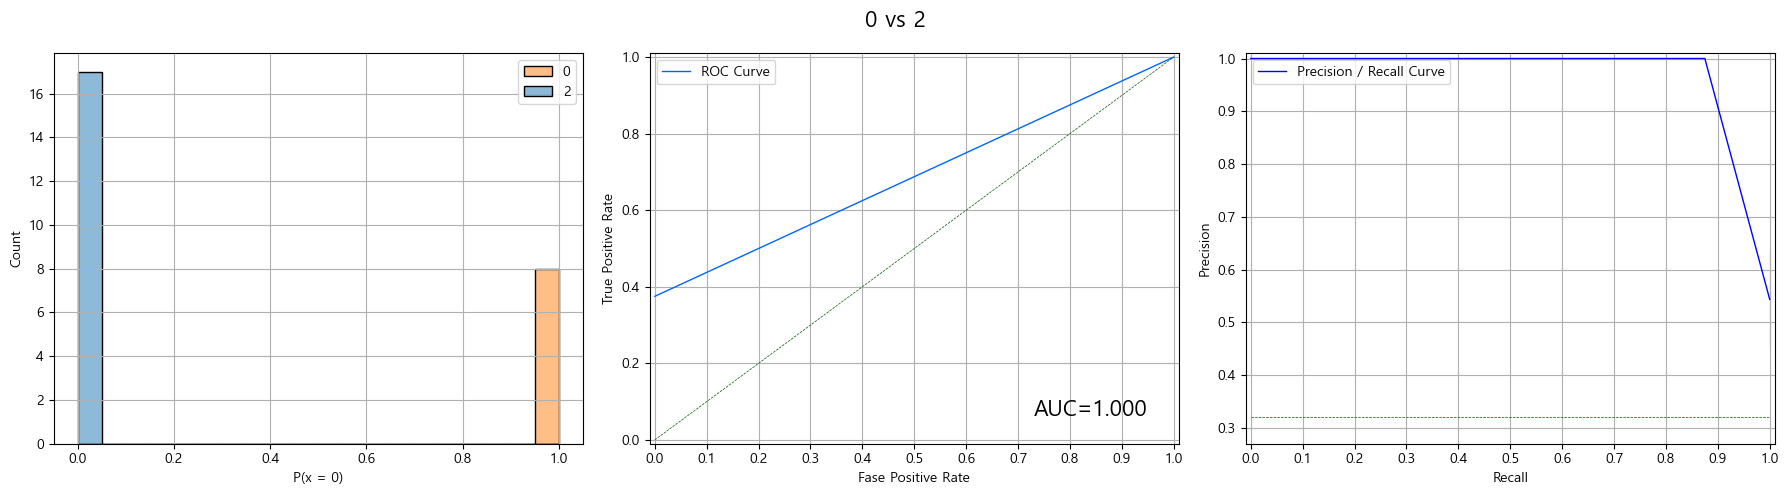

mean roc auc ovo: 1.0000


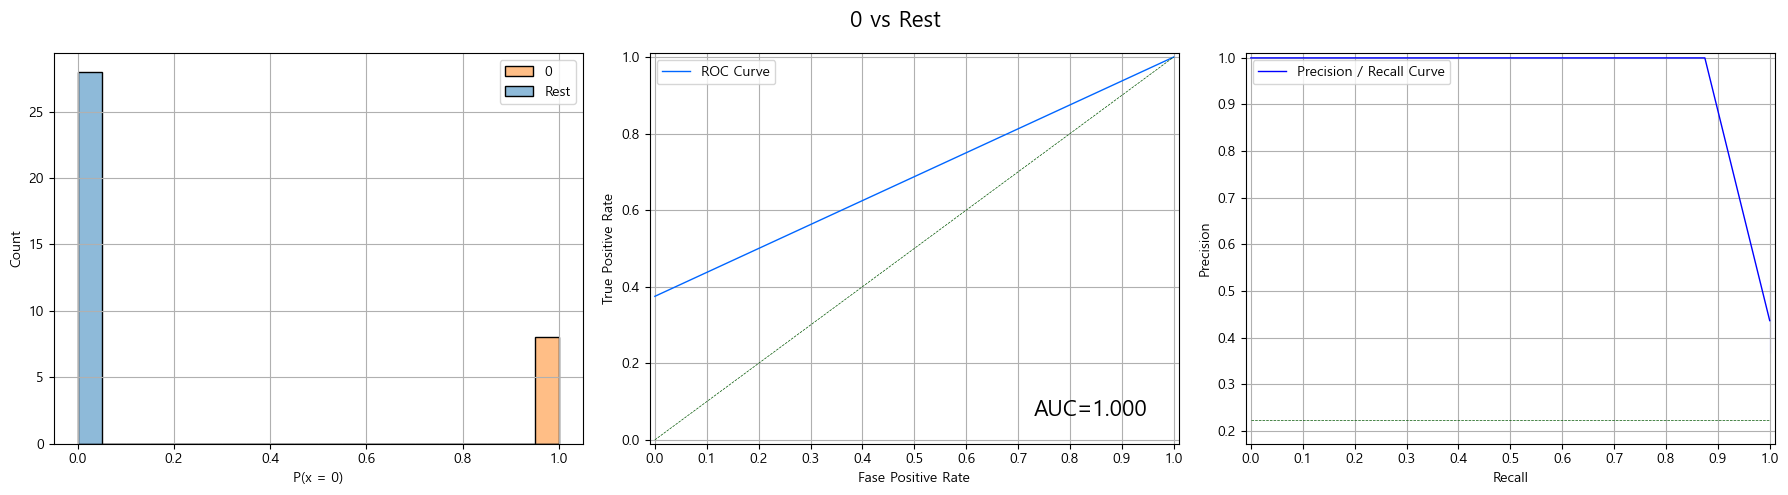

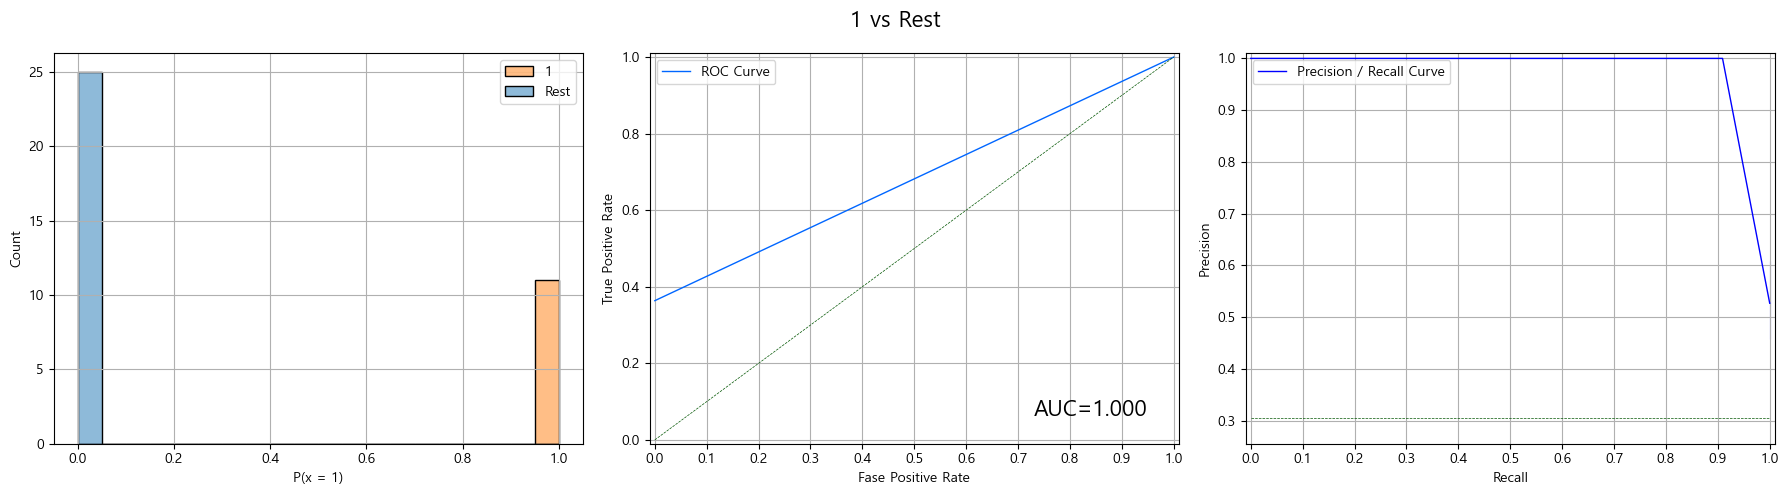

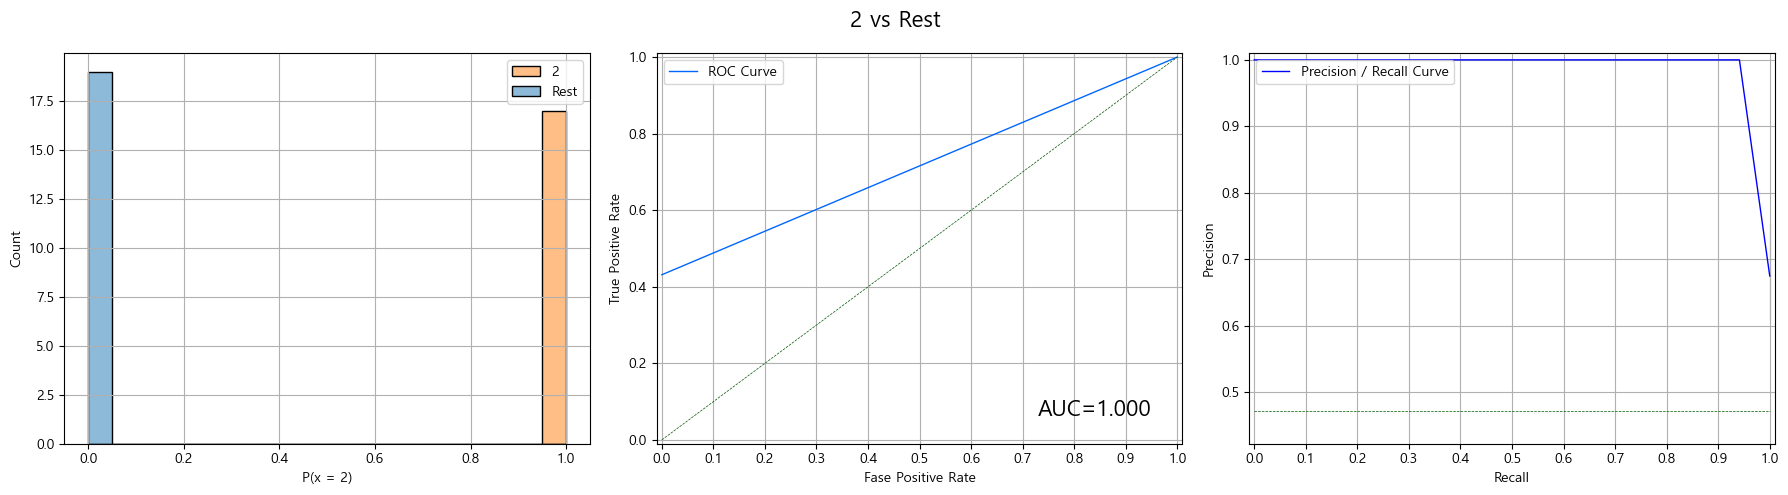

mean roc auc ovo: 1.0000

[학습곡선]


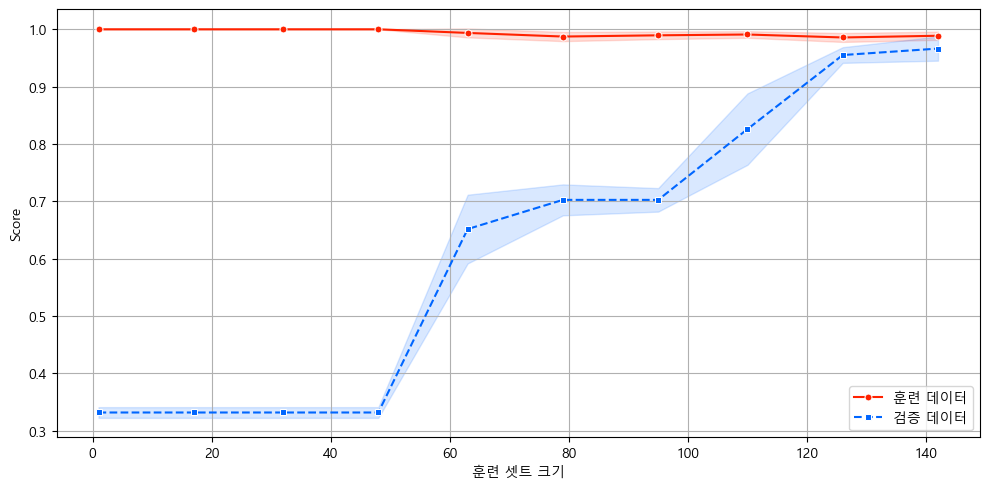

CPU times: total: 5.19 s
Wall time: 5.39 s


GaussianNB()

In [12]:
%%time
my_nb_classification(x_train, y_train, x_test, y_test)

### [4] 모든 모형에 대한 성능 비교

In [13]:
%%time
my_classification(x_train,y_train,x_test,y_test)

<class 'sklearn.naive_bayes.GaussianNB'>는 n_jobs를 허용하지 않음
+----------------------+--------------------+---------------------+------------------+------------+------------+------------+
|                      |   정확도(Accuracy) |   정밀도(Precision) |   재현율(Recall) |   F1 Score |   AUC(ovo) |   AUC(ovr) |
|----------------------+--------------------+---------------------+------------------+------------+------------+------------|
| GaussianNB           |                  1 |                   1 |                1 |          1 |          1 |          1 |
| LogisticRegression   |           0.972222 |            0.972222 |         0.980392 |   0.975406 |   0.999109 |   0.998788 |
| SVC                  |           0.972222 |            0.962963 |         0.969697 |   0.964519 |        nan |        nan |
| KNeighborsClassifier |                  1 |                   1 |                1 |          1 |          1 |          1 |
+----------------------+--------------------+---------------------+--